# Nonparametric methods

Before we learn about nonparametric methods, we'll start by putting them in context against the backdrop of the parametric methods that we've discussed so far in the class.

This section assumes that you've read the first 8-9 sections of statistician Leo Breiman's excellent paper,  [Statistical Modeling: The Two Cultures](https://projecteuclid.org/journals/statistical-science/volume-16/issue-3/Statistical-Modeling--The-Two-Cultures-with-comments-and-a/10.1214/ss/1009213726.full). Generally, the "data modeling" methods described in that paper correspond to the parametric methods that we've learned about so far, while the "algorithmic modeling" methods correspond to the nonparametric methods we'll talk about in these notes.

## Comparing and contrasting

To understand the strengths and weaknesses of the two different approaches for classification, we'll create a simple synthetic dataset and compare two models that we're already familiar with: $k$-nearest neighbor classification and logistic regression.

We'll set up a training dataset with points in a smaller range, and a test dataset with points in a larger range, to help us understand how well the methods generalize.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
N_test = 500
N_train = 150

np.random.seed(2021)

# Create a training dataset
x1_train = np.random.uniform(-1, 1, N_train)
x2_train = np.random.uniform(-1, 1, N_train)

y_train = (x1_train * x2_train > 0).astype(np.int64)

# Create a feature matrix that we can use for classification
X_train = np.vstack([x1_train, x2_train]).transpose()


# Create a test dataset
x1_test = np.random.uniform(-3, 3, N_test)
x2_test = np.random.uniform(-3, 3, N_test)

y_test = (x1_test * x2_test > 0).astype(np.int64)

# Create a feature matrix that we can use to evaluate
X_test = np.vstack([x1_test, x2_test]).transpose()

def draw_results(x1, x2, color, plot_title=''):
    plt.figure()
    plt.scatter(x1, x2, c=color, cmap='viridis', alpha=0.7);
    plt.colorbar()
    plt.title(plot_title)
    plt.axis('equal')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.tight_layout()

/var/folders/tj/sf2pp9mj67d62tbnsw2gjhbw0000gn/T/ipykernel_83687/3203036174.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


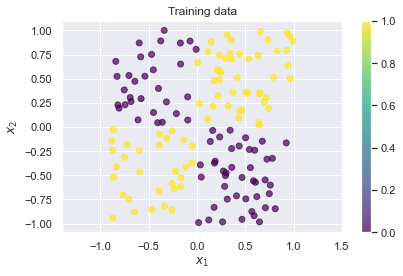

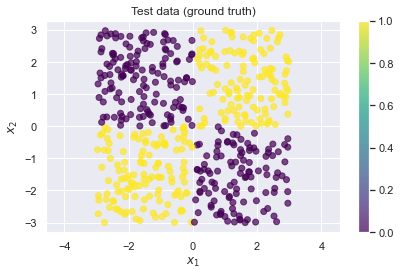

In [3]:
draw_results(x1_train, x2_train, color=y_train, plot_title='Training data')
draw_results(x1_test, x2_test, color=y_test, plot_title='Test data (ground truth)')

We often call datasets like these "toy datasets": they're helpful for illustrating a problem, but they're oversimplified. Real datasets are often more complex, noiser, and higher-dimensional. Whenever you see an example on toy datasets, It's important to keep in mind that there may be additional complications in your dataset.



### Logistic regression

Recall that logistic regression tries to find a linear function of $x_1$ and $x_2$ to use as the decision boundary. In this case, that corresponds to drawing a line on the graph above. Unfortunately, in this case it's nearly impossible to find any linear decision boundary with an accuracy greater than $50\%$ (i.e., random chance guessing): take a moment to convince yourself this is true by mentally drawing lines on the graph above.

/var/folders/tj/sf2pp9mj67d62tbnsw2gjhbw0000gn/T/ipykernel_83687/3203036174.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Accuracy on test set: 0.492


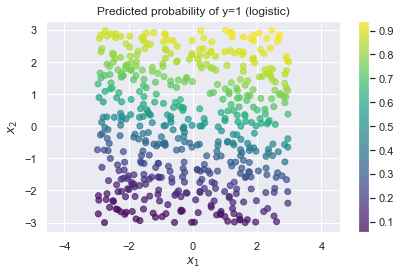

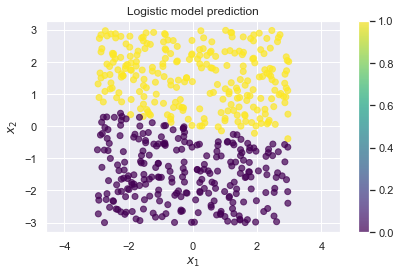

In [4]:
from sklearn.linear_model import LogisticRegression

# Create and fit a scikit-learn logistic regression model on training set
model_logistic = LogisticRegression(penalty='none', solver='lbfgs')
model_logistic.fit(X_train, y_train)

# Use the model to predict on the test set
probs = model_logistic.predict_proba(X_test)[:, 1]
y_hat = (probs > 0.5).astype(np.int64)


# Visualize the results
draw_results(
    x1_test, x2_test, color=probs, 
    plot_title="Predicted probability of y=1 (logistic)"
)

draw_results(
    x1_test, x2_test, color=y_hat, 
    plot_title="Logistic model prediction"
)

accuracy = np.mean(y_test == y_hat)
print(f"Accuracy on test set: {accuracy}")

As expected, the overall accuracy is close to $0.5$ (which is what we'd get if we predicted completely at random). Logistic regression (without any feature engineering) is a poor choice for this data.

### $k$-Nearest Neighbor Classifier

Recall that a $k$-nearest neighbor classifier classifies each point based on the label of the $k$ nearest points in the training set.

/var/folders/tj/sf2pp9mj67d62tbnsw2gjhbw0000gn/T/ipykernel_83687/3203036174.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Accuracy on training set: 0.95


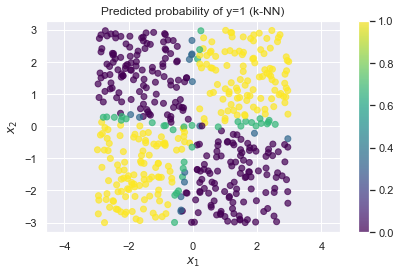

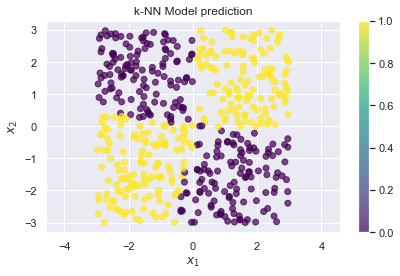

In [5]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=3)
model_knn.fit(X_train, y_train)

probs = model_knn.predict_proba(X_test)[:, 1]
y_hat = (probs > 0.5).astype(np.int64)


draw_results(
    x1_test, x2_test, color=probs, 
    plot_title="Predicted probability of y=1 (k-NN)"
)

draw_results(
    x1_test, x2_test, color=y_hat, 
    plot_title="k-NN Model prediction"
)

accuracy = np.mean(y_test == y_hat)
print(f"Accuracy on training set: {accuracy}")

The kNN model does much better on this dataset. Best of all, we didn't have to do any feature engineering or parameter tuning: it just worked out of the box.

## Comparing and contrasting methods

Let's walk through the pros and cons of these two methods. Note that this is far from an exhaustive list!

### Logistic regression

**PROS**:
* Simple model with only one parameter per input feature (in this case, 2). 
* Parameters can be easily interpreted in a meaningful way: a coefficient $\beta_2$ tells you "If feature $x_2$ increases by a certain amount $a$, the log-odds of $y=1$ increase by $\beta_2 a$."
* The loss function is convex, so there's one best answer and we're guaranteed to get to it.
* Storing/saving the model is cheap, since there are only a few parameters

**CONS**
* Makes an implicit assumption of linear interactions between the inputs (e.g., can't model something like $y = \text{sign}(x_1 x_2)$ as above)
* Modeling complex or nonlinear interactions requires good feature engineering
* Base model is limited in complexity: any complex/nonlinear interactions require lots of feature engineering


### $k$-Nearest Neighbors

**PROS**:
* Makes no assumptions whatsoever about the data (other than that the training data is a representative sample)
* Easy to implement and understand how it works

**CONS**
* Predictions can be interpreted, but we can't do any more meaningful analysis than "this new point looks like these 5 points I saw before, and 3 of those had $y=1$, so that's why I predicted $y=1$".
* Doesn't work as well in high dimensions (but there are some ways around this)
* Saving the model requires saving all the training points (but there are some ways around this)

## Decision trees and random forests

### Decision trees

A decision tree is a method for classification (and regression) that uses a tree-like structure to decide what value to predict for a point. We'll start by taking the entire data. At the root of the tree, we'll split the data based on a particular value of either $x_1$ or $x_2$. We'll then repeat the process for each split, building the tree as deep as we see fit. Our goal in splitting the points is to create as homogeneous a group as possible (in terms of $y$) at the leaves of the tree. Let's look at how we might construct a decision tree for this problem.

1. Our first split is the hardest: we can see that no matter which value of $x_1$ (or $x_2$ we choose, both sides of the split will have half yellow points and half purple points. But, we know that there's a meaningful difference between points where $x_1 > 0$ and points where $x_1 < 0$, so let's choose our first split at $x_1 = 0$. (We could have chosen $x_2 = 0$ too; I picked $x_1$ arbitrarily).

2. Let's start by considering one half of the above split: points where $x_1 > 0$, the right half of the plots above. For these points, there's a very natural split at $x_2 = 0$ that gives us completely homogeneous groups: everything above the split is yellow ($y=1$), and everything below is purple ($y=0$). At this point, we're done splitting this branch of the tree: both sub-branches are completely homogeneous.

3. Next, we'll go back to the points where $x_1 < 0$. It turns out that we can use the same split as before, at $x_2 = 0$. Note that in general, we could have made a different split on this side of the tree! It just so happens with this data that the same sub-split works on both sides of our original split.

And now, we're done. Here's the entire tree:

![](tree_small2.jpeg)

To predict the $y$-value for a new point, we start at the root (top), and continue down until we reach a leaf node. This tree ended up very symmetric, but in many problems that won't be the case.

Here's how it works in scikit-learn:



/var/folders/tj/sf2pp9mj67d62tbnsw2gjhbw0000gn/T/ipykernel_83687/3203036174.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Accuracy on training set: 0.996


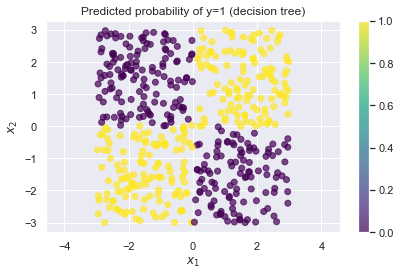

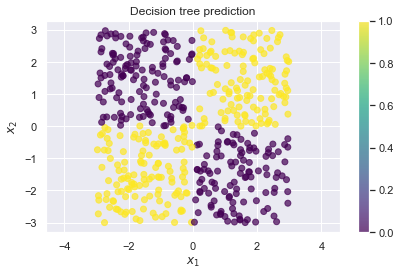

In [6]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

probs = model_tree.predict_proba(X_test)[:, 1]
y_hat = (probs > 0.5).astype(np.int64)


draw_results(
    x1_test, x2_test, color=probs, 
    plot_title="Predicted probability of y=1 (decision tree)"
)

draw_results(
    x1_test, x2_test, color=y_hat, 
    plot_title="Decision tree prediction"
)

accuracy = np.mean(y_test == y_hat)
print(f"Accuracy on training set: {accuracy}")

The decision tree is almost perfect (we'll take a closer look at its mistakes next time).

### From trees to forests

Small decision trees work great for problems where the underlying structure is simple. But what if we our data are noisier? Let's randomly flip a few data points ($10\%$ of our training data) and see what happens:

/var/folders/tj/sf2pp9mj67d62tbnsw2gjhbw0000gn/T/ipykernel_83687/3203036174.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


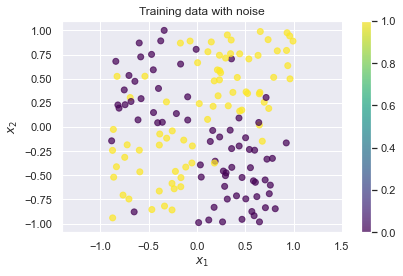

In [7]:
y_train_noisy = y_train.copy()

pts_to_flip = np.random.random(N_train) < 0.1
y_train_noisy[pts_to_flip] = 1 - y_train_noisy[pts_to_flip]

draw_results(x1_train, x2_train, color=y_train_noisy, plot_title='Training data with noise')

In [8]:
y_train.shape

(150,)

/var/folders/tj/sf2pp9mj67d62tbnsw2gjhbw0000gn/T/ipykernel_83687/3203036174.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


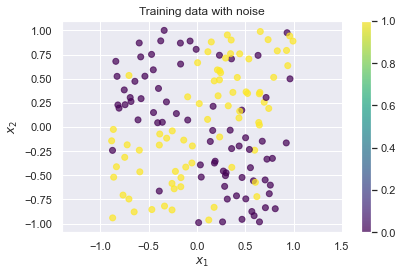

In [9]:
y_train_noisy = y_train.copy()

pts_to_flip = np.random.random(N_train) < 0.1
y_train_noisy[pts_to_flip] = 1 - y_train_noisy[pts_to_flip]

draw_results(x1_train, x2_train, color=y_train_noisy, plot_title='Training data with noise')

Now there are a small handful of points where the training label is wrong. Let's try fitting a decision tree again: we'll train on the noisy data, but we'll test on the good data.

/var/folders/tj/sf2pp9mj67d62tbnsw2gjhbw0000gn/T/ipykernel_83687/3203036174.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Accuracy on training set: 0.648


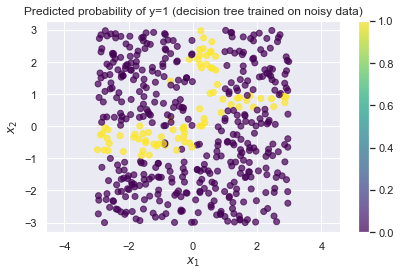

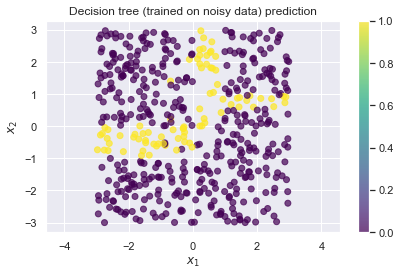

In [10]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train_noisy)

probs = model_tree.predict_proba(X_test)[:, 1]
y_hat = (probs > 0.5).astype(np.int64)


draw_results(
    x1_test, x2_test, color=probs, 
    plot_title="Predicted probability of y=1 (decision tree trained on noisy data)"
)

draw_results(
    x1_test, x2_test, color=y_hat, 
    plot_title="Decision tree (trained on noisy data) prediction"
)

accuracy = np.mean(y_test == y_hat)
print(f"Accuracy on training set: {accuracy}")

Changing just $10\%$ of the points completely wrecked the tree! Our accuracy dropped to around $75\%$.

While this is a toy dataset, it's fairly common in real-world datasets to see $10\%$ of the data be corrupted by noise. We'll fix this using a whole bunch of trees instead of just one. We'll train lots and lots of trees (usually at least 100). Ideally, we would get a fresh dataset for each one, and train each tree separately. Unfortunately, we usually can't get 100 separate datasets, and if we divide our training dataset into 100, we're losing out on valuable data we could use to train our trees.

But, we've already seen a way around this: we can use the bootstrap! Notice that here, we're using bootstrap for a completely different purpose than before: instead of using it to quantify uncertainty, we're using it to improve accuracy. This is called **Bootstrap AGGregation**, or **bagging**. 

The second big idea is **random feature selection**. In this toy example, we've been working with 2 features $x_1$ and $x_2$. But in many real problems, you may have hundreds or even thousands of features. Using the algorithm we have above, for a decision tree to properly deal with that many features, it would have to be extremely deep (since we'd need one node/split for every feature that's relevant). Since we're using multiple trees, we don't need each tree to be perfect. So, we'll just choose a subset of the features for each tree.

In practice, for $K$ features, people use $K/3$ features per tree for **regression** and $\sqrt{K}$ features per tree for **classification** (a previous version of these notes had these flipped).

So, here's how the random forest algorithm works: we train a large number of trees independently, where each one is trained on a bootstrap sample of the data and on a smaller number of features. 

/var/folders/tj/sf2pp9mj67d62tbnsw2gjhbw0000gn/T/ipykernel_83687/3203036174.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Accuracy on training set: 0.848


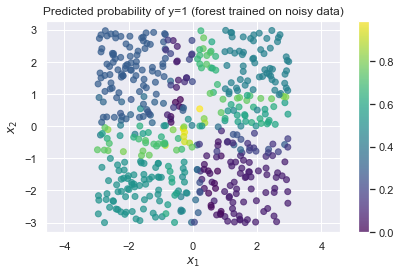

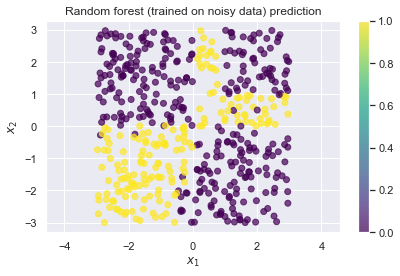

In [11]:

from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier()
model_forest.fit(X_train, y_train_noisy)

probs = model_forest.predict_proba(X_test)[:, 1]
y_hat = (probs > 0.5).astype(np.int64)


draw_results(
    x1_test, x2_test, color=probs, 
    plot_title="Predicted probability of y=1 (forest trained on noisy data)"
)

draw_results(
    x1_test, x2_test, color=y_hat, 
    plot_title="Random forest (trained on noisy data) prediction"
)

accuracy = np.mean(y_test == y_hat)
print(f"Accuracy on training set: {accuracy}")

There are a lot of important details that we haven't covered here. Some of these (e.g., choosing the number of trees) are hyperparameters that we have to decide on using something like cross-validation, while others (e.g., how we decide the best place to split at each iteration while building a tree) are an important part of the algorithm that's beyond what we'll cover in this class. 